# Stochastic Optimization

## 2.1 Genetic Algorithms

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

## Outline

1. [Problem](#problem)
2. [Population](#population)
3. [Evaluation](#evaluation)
4. [Selection](#selection)
5. [Crossover](#crossover)
6. [Mutation](#mutation)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/d9w/evolution/blob/master/2_ga/genetic_algorithm.ipynb)

Today we'll look at an algorithm that can be adapted to meet problem constraints and which is often used in binary or discrete optimization: the Genetic Algorithm. This algorithm uses random selection and genetic recombination in a large population of individuals. By keeping a diverse set of individuals, the Genetic Algorithm can search around multiple **different solutions** to a problem **at the same time**. It has a flexible definition which allows for adaptation to different problems, but the basic components remain the same.

<img src="https://github.com/d9w/evolution/raw/master/imgs/ga.png">

## <a id="problem"></a>Problem

To understand the Genetic Algorithm, we will use it to solve the Travelling Salesman Problem. This is a well-studied problem that simulates a salesman that must visit every city in a list of cities exactly once. The goal is to minimize the total distance traveled. Plenty of applications to this problem exist, such as supply chain management, manufacturing, and navigation.

[![TSP on XKCD](https://imgs.xkcd.com/comics/travelling_salesman_problem.png)](https://xkcd.com/399/)

The TSP is an NP-hard and well-studied problem. The maximum complexity of the problem can be found by assuming an exhaustive search of all possible solutions - for n cities, this is O(n!). Various methods have reduced this computational complexity, including recent algorithms for quantum computers. Genetic Algorithms offer multiple benefits for this problem type, notably scaling up to a large number of cities, being flexible to modifications to the problem such as constraints, and easy parallelization. However, there is not guarantee of an exact solution, only an approximation.

To set up our TSP scenario, we will randomly generate some cities and use their Euclidean distance as the travel cost between them.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

np.random.seed(1234)
rng = np.random.default_rng()
sns.set_theme(style='ticks')

In [3]:
n_cities = 10
cities = np.random.rand(n_cities, 2)

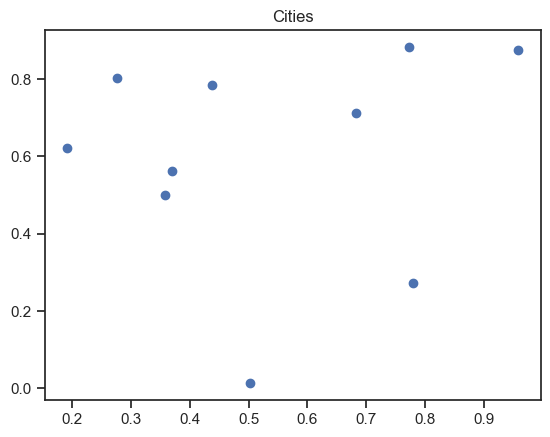

In [4]:
plt.scatter(cities[:, 0], cities[:, 1])
plt.title("Cities");

For our problem of 10 cities, we will calculate the different computational complexities. Remember that we will compare this against the number of **evaluations** in our algorithm (number of generations times the population size).

In [5]:
n = n_cities
print(f"O(n!): {math.factorial(n)}")
print(f"O(n^2 2^n): {n**2 * 2**n}")

O(n!): 3628800
O(n^2 2^n): 102400


## <a id="population"></a>Population

The first decision when using a Genetic Algorithm is the choice of solution representation. To create the first population, we create random solutions (individuals) in this representation (genome), and we'll later modify individuals by combining and mutating the genome. The genome representation depends on the problem, which for this example is the TSP. To represent a solution, we can use the order of cities traveled. Each solution must have each city *exactly once*, ie a permutation of the indices of the list of cities. This is a concise way to represent the path traveled which is also easy to mutate, as we'll see later.

In [6]:
order0 = rng.permutation(n_cities)
order1 = rng.permutation(n_cities)
print(order0)
print(order1)

[8 3 9 4 1 2 7 6 0 5]
[0 7 1 4 9 2 5 8 3 6]


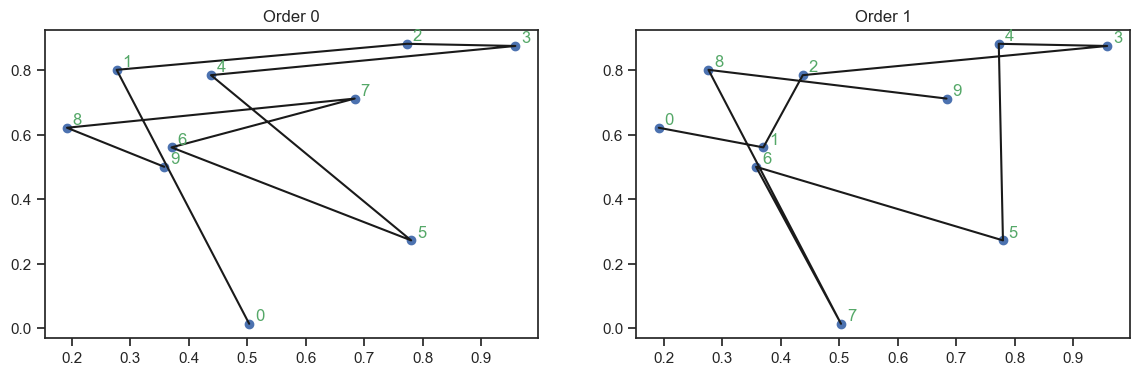

In [7]:
fig = plt.figure(figsize=(14, 4))
ax = plt.subplot(1, 2, 1)
ind = order0
plt.title("Order 0")
ax.scatter(cities[ind, 0], cities[ind, 1])
ax.plot(cities[ind, 0], cities[ind, 1], 'k')
for i in range(n_cities):
    ax.annotate(i, (cities[ind[i], 0]+0.01, cities[ind[i], 1]+0.01), c='g')
ax = plt.subplot(1, 2, 2)
ind = order1
plt.title("Order 1")
ax.scatter(cities[ind, 0], cities[ind, 1])
ax.plot(cities[ind, 0], cities[ind, 1], 'k')
for i in range(n_cities):
    ax.annotate(i, (cities[ind[i], 0]+0.01, cities[ind[i], 1]+0.01), c='g')

For our initial GA population, we will create 100 random permutations. Note that there are $10!$ possible solutions to the (asymmetric) TSP with 10 cities, so 100 is very small compared to the total size. However, it is much larger than the population sizes used by CMA-ES or others. This is one distinguishing feature of Genetic Algorithms: they tend to use larger population sizes in order to represent solutions which are diverse.

In [8]:
n_population = 100
population = np.array([rng.permutation(n_cities) for i in range(n_population)])
population[:5]

array([[4, 8, 0, 3, 1, 5, 2, 9, 6, 7],
       [2, 7, 8, 3, 6, 0, 4, 1, 9, 5],
       [3, 1, 9, 8, 5, 7, 0, 2, 4, 6],
       [7, 4, 9, 5, 2, 3, 6, 8, 0, 1],
       [0, 6, 7, 1, 8, 3, 2, 5, 9, 4]])

## Evaluation

The evaluation step of a Genetic Algorithm is the same as in other stochastic algorithms: each solution must be evaluated by the objective function. In this case, that's the total distance traveled when using the solution order.

In [9]:
d = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    for j in range(i):
        d[i, j] = np.sqrt((cities[i, 0] - cities[j, 0])**2 + (cities[i,1] - cities[j, 1])**2)
        d[j, i] = d[i, j]
d[:3, :3]

array([[0.        , 0.29541331, 0.68442855],
       [0.29541331, 0.        , 0.61649225],
       [0.68442855, 0.61649225, 0.        ]])

In [10]:
def total_distance(order, distances):
    t = 0
    for i in range(1, len(order)):
        t += distances[order[i-1], order[i]]
    return t

In [11]:
print("order 0:", total_distance(order0, d))
print("order 1:", total_distance(order1, d))

order 0: 4.208129093964198
order 1: 3.9717805680843994


In [12]:
def evaluate(population, distances):
    fitness = np.zeros(len(population))
    for i in range(len(population)):
        fitness[i] = total_distance(population[i], distances)
    return fitness

In [13]:
fitness = evaluate(population, d)
for i in range(3):
    print(population[i], fitness[i])
print("Minimum: ")
print(population[np.argmin(fitness)], np.min(fitness), np.max(fitness))

[4 8 0 3 1 5 2 9 6 7] 3.944687022192509
[2 7 8 3 6 0 4 1 9 5] 5.049915576843682
[3 1 9 8 5 7 0 2 4 6] 3.812582354465485
Minimum: 
[1 4 9 5 0 7 3 6 2 8] 3.176583709894986 5.605773368331546


## <a id="selection"></a>Selection

Which individuals should pass on their genetic information to the next generation? We could imagine a simple schemes of taking the best individuals globally, say 20% of them. This is known as truncation selection. In simple problems with no local minima, such a method might work. However, we would lose important genetic diversity, one of the main advantages of the large population in a Genetic Algorithm.

In [14]:
def truncation_selection(population, fitness, p=0.2):
    n_elites = int(np.floor(len(population) * p))
    elites = np.argsort(fitness)[:n_elites]
    return population[elites], fitness[elites]

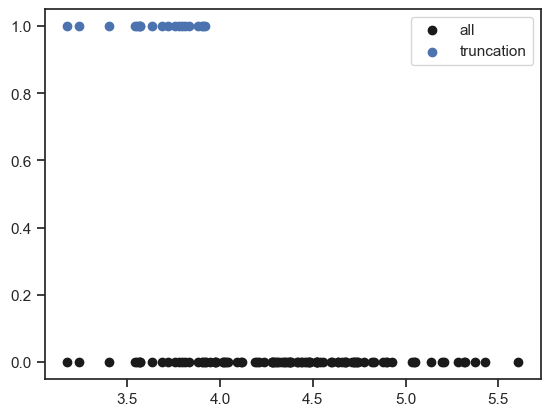

In [15]:
elites, efit = truncation_selection(population, fitness)
plt.scatter(fitness, np.zeros(len(fitness)), color='k', label='all')
plt.scatter(efit, np.ones(len(efit)), color='b', label='truncation')
plt.legend();

To preserve genetic diversity, we'll instead allow any member of the population to have a chance of being selected, based on their fitness. One method would be to draw from the population randomly using a probability based on the fitness of each individual. This is known as fitness proportionate selection. 

In [16]:
def fp_selection(population, fitness):
    p = (np.max(fitness) - fitness)
    p /= np.sum(p)
    rng = np.random.default_rng()
    ind = rng.choice(len(population), p=p)
    return population[ind], fitness[ind]

In [17]:
fp_fits = np.zeros(len(efit))
for i in range(len(efit)):
    p, f = fp_selection(population, fitness)
    fp_fits[i] = f

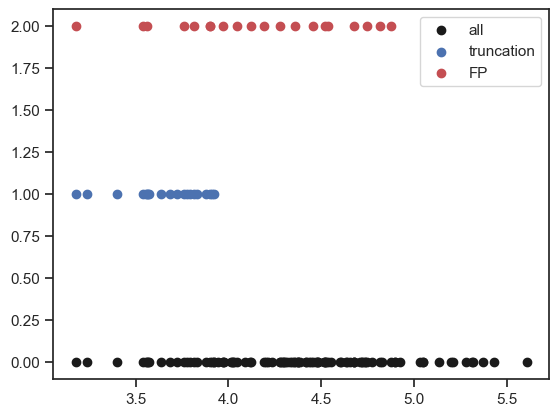

In [34]:
plt.scatter(fitness, np.zeros(len(fitness)), color='k', label='all')
plt.scatter(efit, np.ones(len(efit)), color='b', label='truncation')
plt.scatter(fp_fits, 2*np.ones(len(fp_fits)), color='r', label='FP')
plt.legend();

One of the desirable properties certain evolutionary strategies, notably CMA-ES, is invariance to certain transformations in the search space. Because CMA-ES is based on the **order** of fitness values instead of their value, any transformation of the search space which maintains population order does not affect the search. This makes the search more generalizable to search spaces which are not convex or which are ill-conditioned (think bumpy).

Hansen, Nikolaus, et al. "Impacts of invariance in search: When CMA-ES and PSO face ill-conditioned and non-separable problems." Applied Soft Computing 11.8 (2011): 5755-5769.

In a genetic algorithm, we can acheive the same invariance by using a random ordering of individuals. To do so, we randomly select a subset of individuals, called a tournament, and then take the best individual from that random subset. This is known as tournament selection. Because tournament selection doesn't depend on the absolute fitness value but rather the ranking of individuals in a tournament, it is also invariant to order-preserving transformations.

<div class="alert alert-success">
    <h3>Exercise 1</h3>

Complete the following tournament selection definition which uses a tournament size of `t_size=3`. Plot the selected individuals and compare it to truncation selection and fitness proportionate selection.
</div>

[solution](https://github.com/d9w/evolution/blob/master/2_ga/solutions/ex1.py)

In [32]:
def tournament_selection(population, fitness, t_size=3):
    Nb_tounament = int(len(population)/3)
    tournament = np.random.randint(0, len(population), 3)
    return fp_selection(population[tournament], fitness[tournament])

In [57]:
t_fits = np.zeros(len(efit))
t_elit = np.zeros((len(efit), n_cities))
for i in range(len(efit)):
    p, f = tournament_selection(population, fitness)
    t_fits[i] = f
    t_elit[i] = p

In [58]:
t_elit

array([[3., 8., 2., 7., 9., 4., 6., 0., 5., 1.],
       [2., 0., 8., 5., 4., 7., 6., 1., 3., 9.],
       [0., 7., 2., 6., 8., 3., 5., 4., 9., 1.],
       [5., 0., 4., 7., 3., 1., 9., 8., 2., 6.],
       [6., 4., 3., 9., 0., 7., 2., 8., 5., 1.],
       [2., 8., 6., 4., 3., 0., 5., 1., 7., 9.],
       [2., 4., 5., 3., 8., 0., 7., 1., 9., 6.],
       [3., 9., 0., 5., 7., 2., 8., 1., 4., 6.],
       [3., 5., 4., 6., 9., 2., 7., 0., 1., 8.],
       [2., 6., 0., 5., 3., 1., 7., 4., 8., 9.],
       [1., 7., 9., 6., 4., 8., 3., 0., 2., 5.],
       [8., 3., 1., 5., 2., 4., 6., 7., 0., 9.],
       [7., 0., 1., 5., 3., 6., 9., 4., 8., 2.],
       [8., 3., 1., 5., 2., 4., 6., 7., 0., 9.],
       [3., 2., 0., 5., 9., 7., 1., 6., 4., 8.],
       [0., 7., 2., 6., 8., 3., 5., 4., 9., 1.],
       [1., 0., 4., 9., 6., 7., 8., 2., 5., 3.],
       [8., 3., 1., 5., 2., 4., 6., 7., 0., 9.],
       [3., 1., 9., 8., 5., 7., 0., 2., 4., 6.],
       [5., 3., 9., 0., 1., 8., 6., 7., 2., 4.]])

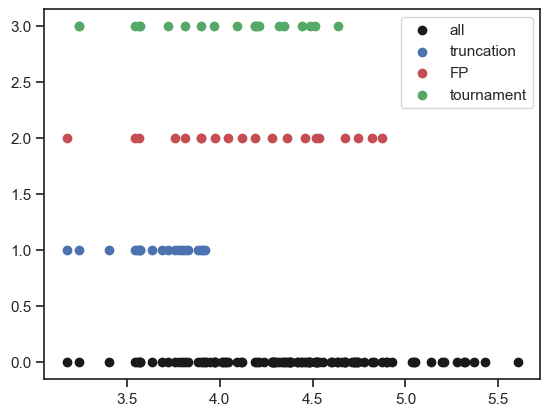

In [35]:
plt.scatter(fitness, np.zeros(len(fitness)), color='k', label='all')
plt.scatter(efit, np.ones(len(efit)), color='b', label='truncation')
plt.scatter(fp_fits, 2*np.ones(len(fp_fits)), color='r', label='FP')
plt.scatter(t_fits, 3*np.ones(len(t_fits)), color='g', label='tournament')
plt.legend();

It is difficult to represent diversity for the TSP, but below there are two different visualizations of the paths present in a population. The first maps all paths on the map, and the second plots a heatmap of the links between different city indices. A diverse population will present a variety of links, so the distribution in the heatmap should be closer to uniform for a diverse selection scheme.

<div class="alert alert-success">
    <h3>Exercise 2</h3>

Using the following visualizations, compare the diversity of the selected population from tournament selection to that of truncation selection. Do you notice a change in the distribution of links present?
</div>

In [36]:
def plot_paths(pop):
    q=np.linspace(0.0, 1.01, len(pop))
    cmap = plt.cm.get_cmap('jet')
    cmaplist = [cmap(x) for x in q]
    plt.scatter(cities[:, 0], cities[:, 1])
    for i in range(len(pop)):
        ind = pop[i]
        plt.plot(cities[ind, 0], cities[ind, 1], color=cmaplist[i], alpha=0.1)

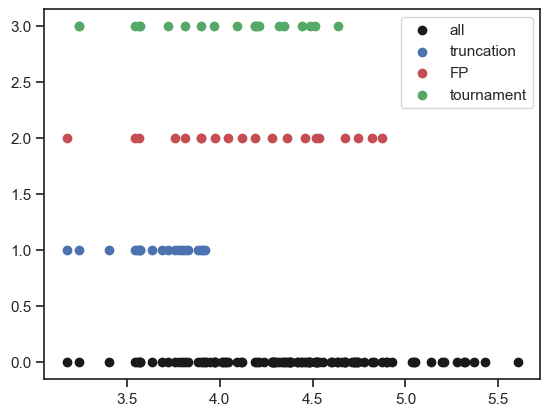

In [37]:
plt.scatter(fitness, np.zeros(len(fitness)), color='k', label='all')
plt.scatter(efit, np.ones(len(efit)), color='b', label='truncation')
plt.scatter(fp_fits, 2*np.ones(len(fp_fits)), color='r', label='FP')
plt.scatter(t_fits, 3*np.ones(len(t_fits)), color='g', label='tournament')
plt.legend();

C:\Users\valentin\AppData\Local\Temp\ipykernel_18504\2817512678.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


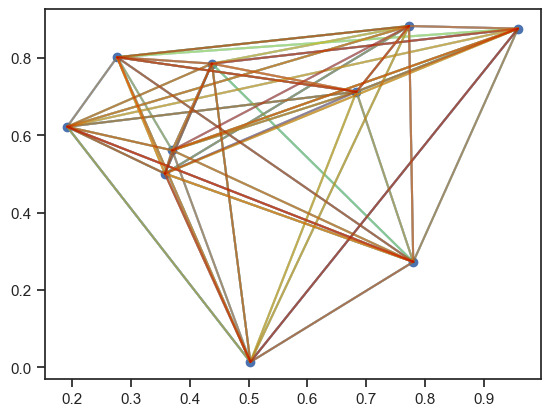

In [38]:
plot_paths(population)

C:\Users\valentin\AppData\Local\Temp\ipykernel_18504\2817512678.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


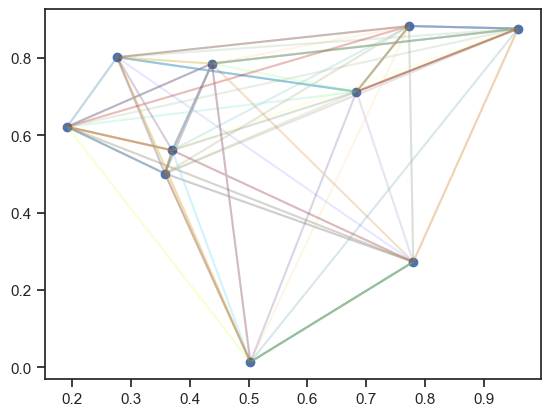

In [39]:
plot_paths(elites)

In [40]:
def get_links(population):
    links = np.zeros((10, 10))
    for i in population:
        for j in range(9):
            links[i[j], i[j+1]] += 1
        links[i[-1], i[0]] += 1
    links /= np.max(links)
    return links

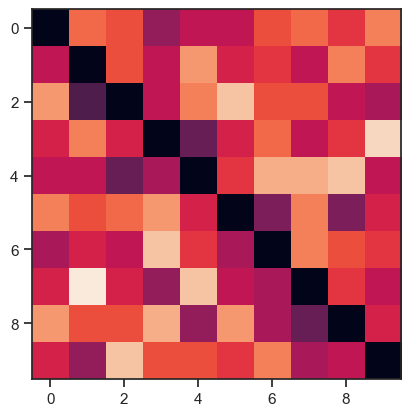

In [41]:
plt.imshow(get_links(population));

In [59]:
plt.imshow(get_links(t_elit));

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## <a id="crossover"></a>Crossover

Considering we have such a large population, is there some way to combine individual solutions to lead to better solutions? For example, could we make an individual which inherits information from two parent individuals? This is the idea behind crossover, the other operator in genetic algorithms besides mutation. It is based on sexual reproduction where the genetic information of two parent individuals is mixed to create an offspring individual. The idea of combining the information from multiple individuals together to create the next generation is something we'll explore in more detail next class when discussing evolutionary strategies. For now, let's look at ways to combine two individuals.

<img src="https://github.com/d9w/evolution/raw/master/imgs/crossover.png" width="80%" height="auto">

In [ ]:
def one_point(p1, p2):
    rng = np.random.default_rng()
    x = rng.choice(np.arange(1, np.minimum(len(p1)-1, len(p2)-1)))
    return np.concatenate((p1[:x], p2[x:])), np.concatenate((p2[:x],p1[x:]))

In [ ]:
parent1, _ = tournament_selection(population, fitness)
parent2, _ = tournament_selection(population, fitness)
print(parent1, parent2)
child1, child2 = one_point(parent1, parent2)
print("crossover: ")
print(child1, child2)

The one point crossover method is a common one, inspired by biology and useful for combining solutions in a number of problems. When increasing the number of swapping points beyond 1, this is known as k-point crossover, and it is useful when the problem dimensions are independent.

In the Travelling Salesman problem, however, the dimensions of the problem are not independent; there is the constraint that all cities must be visited and also that no city can be visted twice. Instead, we'll use a crossover operator which respects those constraints. This is known as the edge recombination operator and it can be applied to any directed graph recombination problem.

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e5/Genetic_ero_crossover.svg" alt="Genetic ero crossover.svg" width="50%" height="auto">

https://en.wikipedia.org/wiki/Edge_recombination_operator
    
Whitley, L. Darrell, Timothy Starkweather, and D'Ann Fuquay. "Scheduling problems and traveling salesmen: The genetic edge recombination operator." ICGA. Vol. 89. 1989. [pdf](TSP_crossover.pdf)

This operator randomly selects from the neighborhood of each node. This operator is rather long to code, so we'll use the [definition](https://github.com/anyoptimization/pymoo/blob/master/pymoo/operators/crossover/erx.py) from the [pymoo](https://pymoo.org/index.html) library. We'll use `pymoo` in the next notebook, so install it now if you haven't yet.

In [60]:
%pip install pymoo

     ---------------------------------------- 0.0/653.8 kB ? eta -:--:--
     --- ----------------------------------- 61.4/653.8 kB 1.6 MB/s eta 0:00:01
     -------- ----------------------------- 153.6/653.8 kB 1.8 MB/s eta 0:00:01
     ----------- -------------------------- 194.6/653.8 kB 1.3 MB/s eta 0:00:01
     ---------------- --------------------- 286.7/653.8 kB 1.6 MB/s eta 0:00:01
     ------------------- ------------------ 337.9/653.8 kB 1.4 MB/s eta 0:00:01
     ----------------------- -------------- 409.6/653.8 kB 1.4 MB/s eta 0:00:01
     ------------------------------ ------- 532.5/653.8 kB 1.5 MB/s eta 0:00:01
     -------------------------------------  645.1/653.8 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 653.8/653.8 kB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/110.5 kB ? eta -:--:--
     --------------------- ----------------- 61.4/110.5 kB 3.2 MB/s eta 0:00:01
     --------------------------- --------- 81.9/110.5 

  DEPRECATION: grapheme is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  DEPRECATION: future is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559


In [61]:
from pymoo.operators.crossover import erx

print("Parents")
print(population[0], population[1])
print("Adjacency Matrix 1")
print(erx.calc_adjency_matrix(population[0]))
print("Adjacency Matrix 2")
print(erx.calc_adjency_matrix(population[1]))
print("Child")
erx.erx(population[0], population[1])

Parents
[4 8 0 3 1 5 2 9 6 7] [2 7 8 3 6 0 4 1 9 5]
Adjacency Matrix 1
{4: {8, 7}, 8: {0, 4}, 0: {8, 3}, 3: {0, 1}, 1: {3, 5}, 5: {1, 2}, 2: {9, 5}, 9: {2, 6}, 6: {9, 7}, 7: {4, 6}}
Adjacency Matrix 2
{2: {5, 7}, 7: {8, 2}, 8: {3, 7}, 3: {8, 6}, 6: {0, 3}, 0: {4, 6}, 4: {0, 1}, 1: {9, 4}, 9: {1, 5}, 5: {9, 2}}
Child


[0, 3, 8, 4, 7, 6, 9, 2, 5, 1]

## <a id="mutation"></a>Mutation

Crossover combines genetic information already existing in the population. In order to search outside the possible combinations of the population, we need to directly modify individuals. This is done using mutation, which is applied either directly to individuals from selection or, more commonly, from the new individuals created by crossover. In general, mutation operators should not greatly modify an individual, changing only a small percentage of genes. An example is uniform mutation, which randomly resamples some genes. A common mutation rate for this is `1/n_genes`, meaning that, on average, only one gene is changed.

As with crossover, we need to create a mutation operator which respects the constraints of the Travelling Salesman Problem. One such mutation operator would be to switch the order of a single random pair of cities, the same "neighbor" generating operator we discussed for Simulated Annealing.

<div class="alert alert-success">
    <h3>Exercise 3</h3>

Complete the following mutation operator definition which inverts a single random pair of cities.
</div>


[solution](https://github.com/d9w/evolution/blob/master/2_ga/solutions/ex2.py)

In [ ]:
def mutate(ind):
    return ind

In [ ]:
print(population[0], population[1])
child = erx.erx(population[0], population[1])
print(child)
mutate(child)

#### Solution to exercise 3

```python
def mutate(ind):
    rng = np.random.default_rng()
    x = rng.choice(len(ind)-1)
    child = np.copy(ind)
    child[x] = ind[x+1]
    child[x+1] = ind[x]
    return child
```

## <a id="ga"></a>The Genetic Algorithm

Now that we have all the different parts, we can combine them in the full genetic algorithm. We'll use two different selection methods: first, a truncation selection of the best few individuals which will pass directly to the next population. This is known as **elitism** and is done to preserve the best solutions between generations. Then, we'll use tournament selection to select parents for crossover. Finally, we'll mutate the result from crossover and pass this new individual into the next population.

In [ ]:
def ga_step(population):
    fitness = evaluate(population, d)
    next_pop, _ = truncation_selection(population, fitness)
    while len(next_pop) < len(population):
        parent1, _ = tournament_selection(population, fitness)
        parent2, _ = tournament_selection(population, fitness)
        child = erx.erx(parent1, parent2)
        child = mutate(child)
        next_pop = np.concatenate((next_pop, [child]))
    return next_pop, fitness

In [ ]:
n_cities = 20
cities = np.random.rand(n_cities, 2)
d = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    for j in range(i):
        d[i, j] = np.sqrt((cities[i, 0] - cities[j, 0])**2 + (cities[i,1] - cities[j, 1])**2)
        d[j, i] = d[i, j]

In [ ]:
n_population = 100
n_gen = 100
population = np.array([rng.permutation(n_cities) for i in range(n_population)])
minfit = np.zeros(n_gen)
for i in range(n_gen):
    population, fitness = ga_step(population)
    minfit[i] = np.min(fitness)
    if i > 2 and minfit[i] < minfit[i-1]:
        print(i, minfit[i])

In [ ]:
plt.plot(minfit);

<div class="alert alert-success">
    <h3>Exercise 3</h3>

Study the impact of the crossover operator. Change the definition of the genetic algorithm to only use mutation from a single parent. How does this compare to using the ERX? What about when using a one-point crossover?
</div>

<div class="alert alert-success">
    <h3>Exercise 4</h3>

Study two hyperparameters of the genetic algorithm: the population size and the number of elites. How do these affect the search? Are elites necessary?
</div>

<div class="alert alert-info">
    <h3>Discussion</h3>

In the Genetic Algorithm, how many evaluations were performed? Is this the same as the total number of permutations explored? Roughly, how many permutations were calculated compared to the total number of possible city permutations? Has the GA converged on the best possible solution? When should the GA stop?
</div>